Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# 1. Подготовка

In [1]:
!python3 -m spacy download en_core_web_sm 

Defaulting to user installation because normal site-packages is not writeable
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [1]:
# Блок импорта
import pandas as pd
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from pymystem3 import Mystem

from spacy.lemmatizer import Lemmatizer
from spacy.lookups import Lookups
import spacy
import en_core_web_sm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
from sklearn.linear_model import LogisticRegression

from sklearn.utils import shuffle

from tqdm import tqdm
import torch
from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForMaskedLM
import transformers
from tqdm import notebook

from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

In [2]:
# Поскольку лемматизация выполняется по часу и остальные операции также совсем не быстрые, для удоства после всей обработки 
# сохраним наш DF в отдельном файле

PREPARED_CSV = 'prepared-text.csv'

# Константа будет определять, использовать подготовленный DF или пересобирать все заново
USE_PREPARED_CSV = True

In [4]:
# Получим список стоп-слов
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# Определим константы
RANDOM_STATE = 12345
TARGET_NAME = 'toxic'

In [6]:
# Загрузим данные
df = pd.read_csv('/datasets/toxic_comments.csv')
df.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [7]:
if USE_PREPARED_CSV:
    df = pd.read_csv(PREPARED_CSV)

### Примерный алгоритм работы

    1. Проверим баланс классов
    2. Изучим дополнительные параметры текста
    3. Соберем леммы из нашего текста
    4. Очистим текст от лишних символов и приведем все к нижнему регистру для унификации
    5. Подумаем над метапризнаками для лучшего обучения модели

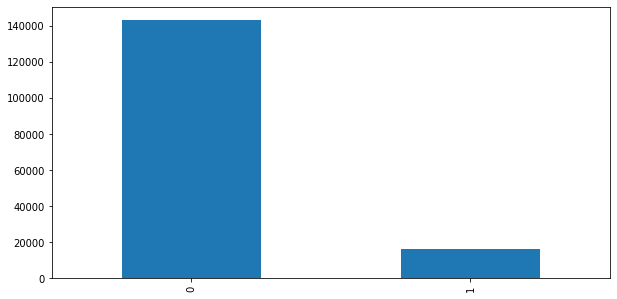

In [8]:
# Проверим дисбаланс
df[TARGET_NAME].value_counts().plot(kind='bar', figsize=(10, 5))

Внезапно имеем солидный дисбаланс классов, нужно будет учесть это при обучении.

In [9]:
# Посмотрим на параметры текста
min_size_all = df['text'].str.len().min()
min_size_all

6

In [10]:
max_size_all = df['text'].str.len().max()
max_size_all

5000

In [11]:
# Проверим, что у нас действительно только английский текст
russian_regexp = r'[а-яА-ЯёЁ]'
english_regexp = r'[A-Za-z]'

def check_russian(value):
    return int(re.search(russian_regexp, value) is not None)

df['is_russian'] = df['text'].apply(check_russian)
df['is_russian'].value_counts()

0    159312
1       259
Name: is_russian, dtype: int64

In [12]:
# Посмотрим, что за русские ребята
pd.set_option('display.max_colwidth', -1)
print(df[df['is_russian'] == 1]['text'].head(2))

126    Ahh, Hello Witzeman \n\n203.92.84.161  \nSymbols: ~ | ¡ ¿ † ‡ ↔ ↑ ↓ • ¶   # ½ ⅓ ⅔ ¼ ¾ ⅛ ⅜ ⅝ ⅞ ∞   ‘ “ ’ ” «»   ¤ ₳ ฿ ₵ ¢ ₡ ₢ $ ₫ ₯ € ₠ ₣ ƒ ₴ ₭ ₤ ℳ ₥ ₦ № ₧ ₰ £ ៛ ₨ ₪ ৳ ₮ ₩ ¥   ♠ ♣ ♥ ♦   m² m³ \nCharacters: Á á Ć ć É é Í í Ĺ ĺ Ń ń Ó ó Ŕ ŕ Ś ś Ú ú Ý ý Ź ź   À à È è Ì ì Ò ò Ù ù   Â â Ĉ ĉ Ê ê Ĝ ĝ Ĥ ĥ Î î Ĵ ĵ Ô ô Ŝ ŝ Û û Ŵ ŵ Ŷ ŷ   Ä ä Ë ë Ï ï Ö ö Ü ü Ÿ ÿ   ß   Ã ã Ẽ ẽ Ĩ ĩ Ñ ñ Õ õ Ũ ũ Ỹ ỹ   Ç ç Ģ ģ Ķ ķ Ļ ļ Ņ ņ Ŗ ŗ Ş ş Ţ ţ   Đ đ   Ů ů   Ǎ ǎ Č č Ď ď Ě ě Ǐ ǐ Ľ ľ Ň ň Ǒ ǒ Ř ř Š š Ť ť Ǔ ǔ Ž ž   Ā ā Ē ē Ī ī Ō ō Ū ū Ȳ ȳ Ǣ ǣ   ǖ ǘ ǚ ǜ Ă ă Ĕ ĕ Ğ ğ Ĭ ĭ Ŏ ŏ Ŭ ŭ   Ċ ċ Ė ė Ġ ġ İ ı Ż ż   Ą ą Ę ę Į į Ǫ ǫ Ų ų   Ḍ ḍ Ḥ ḥ Ḷ ḷ Ḹ ḹ Ṃ ṃ Ṇ ṇ Ṛ ṛ Ṝ ṝ Ṣ ṣ Ṭ ṭ   Ł ł   Ő ő Ű ű   Ŀ ŀ   Ħ ħ   Ð ð Þ þ   Œ œ   Æ æ Ø ø Å å   Ə ə    \nGreek: Ά ά Έ έ Ή ή Ί ί Ό ό Ύ ύ Ώ ώ   Α α Β β Γ γ Δ δ   Ε ε Ζ ζ Η η Θ θ   Ι ι Κ κ Λ λ Μ μ   Ν ν Ξ ξ Ο ο Π π   Ρ ρ Σ σ ς Τ τ Υ υ   Φ φ Χ χ Ψ ψ Ω ω    \nCyrillic: А а Б б В в Г г   Ґ ґ Ѓ ѓ Д д Ђ ђ   Е е Ё ё Є є Ж ж   З з Ѕ ѕ И и І і   Ї ї Й й Ј ј К к   Ќ ќ Л л Љ љ М м   Н н Њ њ О о П п   Р р

In [13]:
# Вернем, как было
pd.set_option('display.max_colwidth', 50)
del df['is_russian']

### Небольшая ремарка

    1. Думаю, в итоге, можно считать, что мы работаем только с комментариями на английском
    2. Очистим текст. Проблема в том, что оставить просто буквы будет не совсем верно, т.к. в английском языке I'm, например, превратится в Im, если заменять на пустую строку небуквенные символы. При этом, если заменять на пробел, получим I m. Т.е. букву m, которую еще нужно правильно интерпретировать. 
    
    Тут я не знаю, как правильно поступить, но пойду вторым путем (замена на пробел + дополнительная обработка согласно правилам языка)

In [14]:
# Создадим столбец для обработанного текста, сразу приведем к нижнему регистру
if not USE_PREPARED_CSV:
    df['text_prepared'] = df['text'].str.lower()
    
    reduction_dict = dict()
    reduction_dict["i'm"] = 'i am'
    reduction_dict["i'd"] = 'i had'
    reduction_dict["i'll"] = 'i will'
    reduction_dict["i've"] = 'i have'
    reduction_dict["you're"] = 'you are'
    reduction_dict["you'd"] = 'you had'
    reduction_dict["you'll"] = 'you will'
    reduction_dict["you've"] = 'you have'
    reduction_dict["he's"] = 'he is'
    reduction_dict["he'd"] = 'he had'
    reduction_dict["he'll"] = 'he will'
    reduction_dict["she's"] = 'she is'
    reduction_dict["she'd"] = 'she had'
    reduction_dict["she'll"] = 'she will'
    reduction_dict["it's"] = 'it is'
    reduction_dict["it'll"] = 'it will'
    reduction_dict["we're"] = 'we are'
    reduction_dict["we'd"] = 'we would'
    reduction_dict["we'll"] = 'we will'
    reduction_dict["we've"] = 'we have'
    reduction_dict["they're"] = 'they are'
    reduction_dict["they'd"] = 'they had'
    reduction_dict["they'll"] = 'they will'
    reduction_dict["they've"] = 'they have'
    reduction_dict["there's"] = 'there is'
    reduction_dict["there'll"] = 'there will'
    reduction_dict["there'd"] = 'there would'
    reduction_dict["isn't"] = 'is not'
    reduction_dict["aren't"] = 'are not'
    reduction_dict["don't"] = 'do not'
    reduction_dict["doesn't"] = 'does not'
    reduction_dict["wasn't"] = 'was not'
    reduction_dict["weren't"] = 'were not'
    reduction_dict["didn't"] = 'did not'
    reduction_dict["haven't"] = 'have not'
    reduction_dict["hasn't"] = 'has not'
    reduction_dict["won't"] = 'will not'
    reduction_dict["hadn't"] = 'had not'
    reduction_dict["can't"] = 'cannot'
    reduction_dict["couldn't"] = 'could not'
    reduction_dict["mustn't"] = 'must not'
    reduction_dict["mightn't"] = 'might not'
    reduction_dict["needn't"] = 'need not'
    reduction_dict["shouldn't"] = 'should not'
    reduction_dict["oughtn't"] = 'ought not'
    reduction_dict["wouldn't"] = 'would not'
    reduction_dict["what's"] = 'what is'
    reduction_dict["how's"] = 'how is'
    reduction_dict["where's"] = 'where is'

    def uncover_reduction(string):
        # Чтобы ускориться, заменим все символы ’ на '
        string_tmp = string.replace('’', "'")
    
        # Чтобы не перебирать все ключи для каждой строки, для начала отсеим строки, которые вообще не содержат символы сокращений
        if (string_tmp.find("'") == -1):
            return string_tmp
    
        # Даже если нашли, это могли быть просто слова в кавычках, проверим, что они попадают под сокращения
        parts = ("'s ", "'t ", "'ll ", "'ve ", "'m ", "'d ", "'re ")
        founded = False
        for part in parts:
            if (string_tmp.find(part) != -1):
                founded = True
                break;
    
        # если не нашли сокращения, возвращаем строку как есть (после замены)
        if not founded:
            return string_tmp
    
        # если нашли сокращения, используем наш словарь и производим замены
        for key, value in reduction_dict.items():
            string_tmp = string_tmp.replace(key, value)
        
        return string_tmp

    df['text_prepared'] = df['text_prepared'].apply(uncover_reduction)

df[['text', 'text_prepared']].head()

,text,text_prepared
0,Explanation\nWhy the edits made under my usern...,explanation\nwhy the edits made under my usern...
1,D'aww! He matches this background colour I'm s...,d'aww! he matches this background colour i am ...
2,"Hey man, I'm really not trying to edit war. It...","hey man, i am really not trying to edit war. i..."
3,"""\nMore\nI can't make any real suggestions on ...","""\nmore\ni cannot make any real suggestions on..."
4,"You, sir, are my hero. Any chance you remember...","you, sir, are my hero. any chance you remember..."


In [15]:
# Очистим текст. Только сделаем это в отдельном поле, т.к. подготовленный текст может понадобится для других моделей

if not USE_PREPARED_CSV:
    def clean_text(string):
        string = re.sub(r"[\n\r]", " ", string)
        string = re.sub(r"[^a-zA-Z ]+", "", string)
        return string.strip()

    df['text_cleared'] = df['text_prepared'].apply(clean_text)

df[['text', 'text_cleared']].head()

,text,text_cleared
0,Explanation\nWhy the edits made under my usern...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,daww he matches this background colour i am se...
2,"Hey man, I'm really not trying to edit war. It...",hey man i am really not trying to edit war it ...
3,"""\nMore\nI can't make any real suggestions on ...",more i cannot make any real suggestions on imp...
4,"You, sir, are my hero. Any chance you remember...",you sir are my hero any chance you remember wh...


In [16]:
%%time

# Проведем лемматизацию
if not USE_PREPARED_CSV:
    lookups = Lookups()
    lookups.add_table("lemma_rules", {"noun": [["s", ""]]})
    lemmatizer = Lemmatizer(lookups)
    nlp = en_core_web_sm.load()

    def lemmatize(string):
        result = []
        for token in nlp(string):
            # тут же очистим стоп-слова
            if token.is_stop == False:
                result.append(token.lemma_)
        return ' '.join(result)

    df['text_lemmas'] = df['text_cleared'].apply(lemmatize)

df[['text', 'text_lemmas']].head()

CPU times: user 7.47 ms, sys: 3.93 ms, total: 11.4 ms
Wall time: 10.9 ms


,text,text_lemmas
0,Explanation\nWhy the edits made under my usern...,explanation edit username hardcore metallica f...
1,D'aww! He matches this background colour I'm s...,daww match background colour seemingly stuck t...
2,"Hey man, I'm really not trying to edit war. It...",hey man try edit war guy constantly remove rel...
3,"""\nMore\nI can't make any real suggestions on ...",real suggestion improvement wonder section s...
4,"You, sir, are my hero. Any chance you remember...",sir hero chance remember page s


In [17]:
# Сохраним подготовленный CSV
df.to_csv(PREPARED_CSV)

In [18]:
# Подчеркнул идею в другой работе - добавим метапризнаки по нашему тексту

# Количество символов
df['char_count'] = df['text'].str.len()

# Количество слов и уникальных слов
df['words_count'] = df['text_cleared'].str.count(' ') + 1

# знаю, что можно решить проще, но пытался по разному - либо юпитер падает, либо выдает не то, что надо
def unique_words_counter(string):
    string = str(string)
    return len(set(string.split()))

df['words_unique_count'] = df['text_cleared'].apply(unique_words_counter)

# Наличие стоп-слов
def bad_words_counter(string):
    string = str(string)
    words = string.split()
    result_counter = 0
    for word in words:
        if word in STOP_WORDS:
            result_counter += 1
    
    return result_counter
            

df['bad_words_count'] = df['text'].apply(bad_words_counter)

# Средняя длина слова
def word_len_mean_counter(string):
    string = str(string)
    words = string.split()
    return sum(len(word) for word in words) / len(words)

df['words_len_mean'] = df['text'].apply(word_len_mean_counter)

df[['text', 'char_count', 'words_count', 'words_unique_count', 'bad_words_count', 'words_len_mean']].head()

,text,char_count,words_count,words_unique_count,bad_words_count,words_len_mean
0,Explanation\nWhy the edits made under my usern...,264,46.0,41,14,5.162791
1,D'aww! He matches this background colour I'm s...,112,19.0,15,1,5.588235
2,"Hey man, I'm really not trying to edit war. It...",233,44.0,40,18,4.571429
3,"""\nMore\nI can't make any real suggestions on ...",622,114.0,77,49,4.486726
4,"You, sir, are my hero. Any chance you remember...",67,13.0,12,4,4.230769


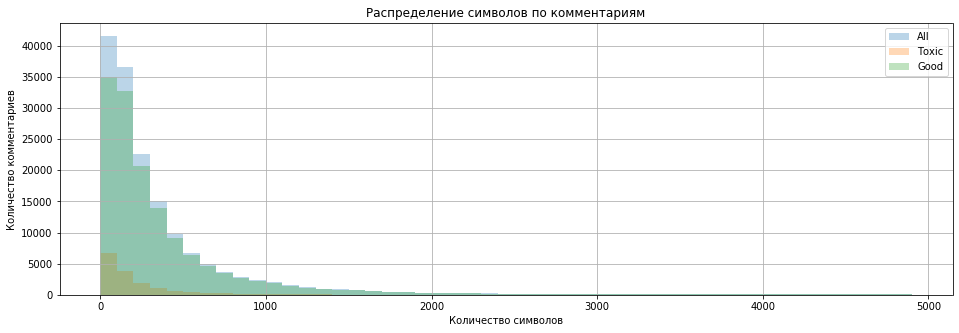

In [19]:
# Выведем графики

fig, ax = plt.subplots(1)
ax.set_title('Распределение символов по комментариям')
ax.set_xlabel('Количество символов')
ax.set_ylabel('Количество комментариев')

df['char_count'].hist(bins=range(0, 5000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='All')
df[df['toxic'] == 1]['char_count'].hist(bins=range(0, 5000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Toxic')
df[df['toxic'] == 0]['char_count'].hist(bins=range(0, 5000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Good')
ax.legend()

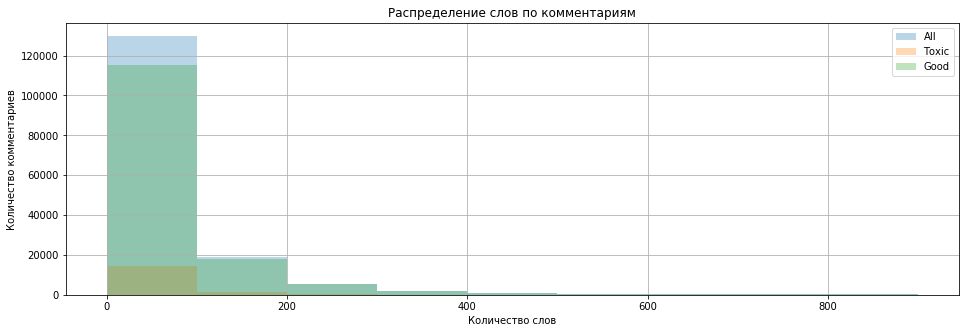

In [20]:
fig, ax = plt.subplots(1)
ax.set_title('Распределение слов по комментариям')
ax.set_xlabel('Количество слов')
ax.set_ylabel('Количество комментариев')

df['words_count'].hist(bins=range(0, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='All')
df[df['toxic'] == 1]['words_count'].hist(bins=range(0, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Toxic')
df[df['toxic'] == 0]['words_count'].hist(bins=range(0, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Good')
ax.legend()

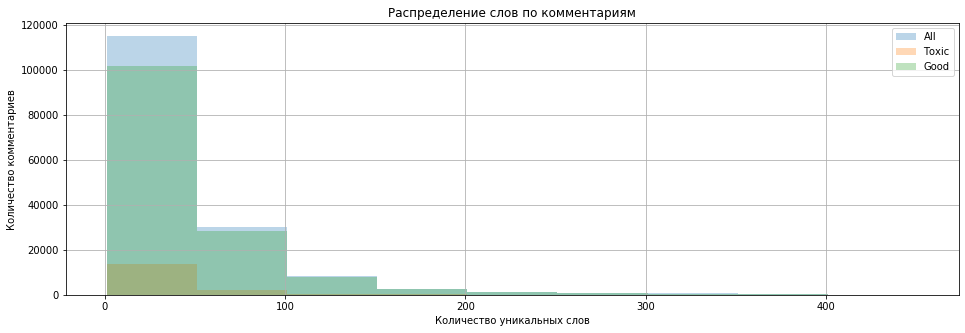

In [21]:
fig, ax = plt.subplots(1)
ax.set_title('Распределение слов по комментариям')
ax.set_xlabel('Количество уникальных слов')
ax.set_ylabel('Количество комментариев')

df['words_unique_count'].hist(bins=range(1, 500, 50), figsize=(16,5), alpha=0.3, ax=ax, label='All')
df[df['toxic'] == 1]['words_unique_count'].hist(bins=range(1, 500, 50), figsize=(16,5), alpha=0.3, ax=ax, label='Toxic')
df[df['toxic'] == 0]['words_unique_count'].hist(bins=range(1, 500, 50), figsize=(16,5), alpha=0.3, ax=ax, label='Good')
ax.legend()

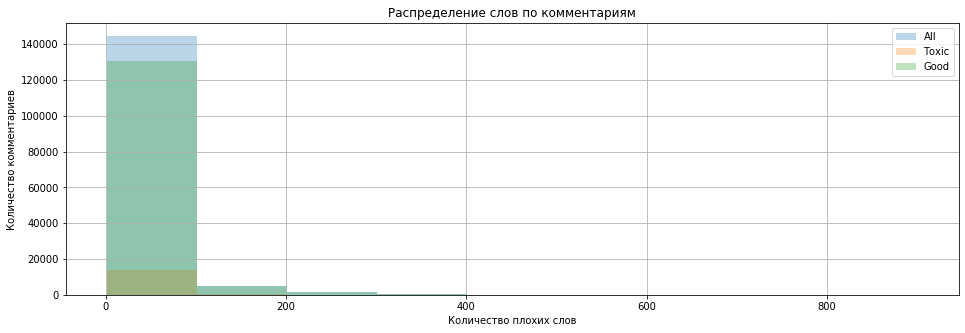

In [22]:
fig, ax = plt.subplots(1)
ax.set_title('Распределение слов по комментариям')
ax.set_xlabel('Количество плохих слов')
ax.set_ylabel('Количество комментариев')

df['bad_words_count'].hist(bins=range(1, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='All')
df[df['toxic'] == 1]['bad_words_count'].hist(bins=range(1, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Toxic')
df[df['toxic'] == 0]['bad_words_count'].hist(bins=range(1, 1000, 100), figsize=(16,5), alpha=0.3, ax=ax, label='Good')
ax.legend()

In [23]:
# Посмотрим, что за фрукт
df[(df['toxic'] == 0) & (df['bad_words_count'] == 411)]

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,Unnamed: 0.1.1.1.1,text,toxic,text_prepared,text_cleared,char_count,words_count,words_unique_count,bad_words_count,words_len_mean,text_lemmas
154504,154504,154504,154504,154504,154504,"""\n\n Issue on images still unresolved \n\nSli...",0,"""\n\n issue on images still unresolved \n\nsli...",issue on images still unresolved slim i am c...,4653,891.0,348,411,4.458726,issue image unresolved slim copy message re...


### Промежуточный вывод

    Мы обработали наши данные. В целом особенных отличий плохих комментариев от хороших не особо много, но выглядит так, что токсичные комментарии обычно меньше по размеру и содержат меньше уникальных слов. По гистограммам хорошо виден дисбаланс наших классов, который мы учтем в дальнейшем.

# 2. Обучение

In [24]:
# Поскольку бесконечно ждать логистическую регрессию нет никакого желания, а за BERT так вообще переживается в тренажере
# проведем сразу downsampling, вместо использования class_balanced
# (забегая вперед, downsampling сильно улучшил метрику)

df_toxic = df[df['toxic'] == 1]
df_not_toxic = df[df['toxic'] == 0]

df_downsampled = pd.concat([df_toxic] + [df_not_toxic.sample(n=16225, random_state=RANDOM_STATE)])
df_downsampled['toxic'].value_counts()

1    16225
0    16225
Name: toxic, dtype: int64

In [25]:
# Подготовим признаки
df_downsampled = df_downsampled.dropna()
features = df_downsampled['text_lemmas']
target = df_downsampled['toxic']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, shuffle=True, random_state=RANDOM_STATE)

features_train.shape, features_test.shape

((25949,), (6488,))

In [26]:
# Посмотрим на Tf-idf и логистическую регрессию

count_tf_idf = TfidfVectorizer(stop_words=STOP_WORDS) 
count_tf_idf.fit(features_train) 
tf_idf = count_tf_idf.transform(features_train)

# Определим scorer

f1 = make_scorer(f1_score, average='macro')

In [27]:
%%time

# Посмотрим на параметры

parameters = {'C': (0.1, 0.5, 1.0), 'fit_intercept': (True, False), 'solver': ('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
#grid = GridSearchCV(model, parameters, cv=3, scoring=f1)
#grid.fit(tf_idf, target_train)

#grid.best_params_

# Для отладки - {'C': 1.0, 'fit_intercept': True, 'solver': 'saga'}

CPU times: user 22 µs, sys: 2 µs, total: 24 µs
Wall time: 28.8 µs


In [28]:
model = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced', fit_intercept=True, C=1.0, solver='saga')
model.fit(tf_idf, target_train)

tf_idf_test = count_tf_idf.transform(features_test)
predicted = model.predict(tf_idf_test)

f1_score(target_test, predicted)

0.8859188544152744

In [29]:
# Хотя мы уже получили нужный скор, задание требует того, чтобы мы использовали несколько моделей
# Поэтому попробуем SVC

parameters = {'C': (0.5, 1.0), 'kernel': ('linear', 'poly', 'rbf')}
model = SVC(random_state=RANDOM_STATE, class_weight='balanced')
#grid = GridSearchCV(model, parameters, cv=3, scoring=f1)
#grid.fit(tf_idf, target_train)

#grid.best_params_

# Итог - {'C': 1.0, 'kernel': 'linear'}

In [30]:
%%time
# Обучим модель
model = SVC(random_state=RANDOM_STATE, class_weight='balanced', C=1.0, kernel='linear', gamma='auto')
model.fit(tf_idf, target_train)

CPU times: user 2min 51s, sys: 333 ms, total: 2min 51s
Wall time: 2min 55s


SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=12345, shrinking=True,
    tol=0.001, verbose=False)

In [31]:
# Посмотрим, что получилось.
predicted = model.predict(tf_idf_test)

f1_score(target_test, predicted)

0.8930599369085173

In [32]:
# Проверим модель на адекватность
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(tf_idf, target_train)
predicted = dummy_clf.predict(tf_idf_test)
f1_score(target_test, predicted)

0.6699466994669947

## Попробуем Bert

## ВАЖНО

<span style="color:blue"> В общем, я честно пытался использовать BERT, но тренажер не вывозит даже на минимальных признаках и с разными размерами батчей. Лучший результат, что удалось достичь до того, как умирает ядро тут - https://clip2net.com/s/4a0AW2H</span>

In [33]:
# BERT в тренажере совсем плохо, поэтому поставим по 1000 записей и посмотрим, что будет

df_toxic = df[df['toxic'] == 1]
df_not_toxic = df[df['toxic'] == 0]

df_downsampled_bert = pd.concat([df_toxic.sample(n=1000, random_state=RANDOM_STATE)] + [df_not_toxic.sample(n=1000, random_state=RANDOM_STATE)])
df_downsampled_bert['toxic'].value_counts()

1    1000
0    1000
Name: toxic, dtype: int64

In [34]:
# Загрузим модель
model = BertModel.from_pretrained('bert-base-uncased')
model.eval();

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [35]:
%%time
tokenized = df_downsampled_bert['text_cleared'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512))

CPU times: user 4.14 s, sys: 24 µs, total: 4.14 s
Wall time: 4.16 s


In [36]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)
        
padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])
padded.shape

(2000, 512)

In [37]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(2000, 512)

In [38]:
#config = transformers.BertConfig.from_json_file(
#    '/datasets/ds_bert/bert_config.json')
#model = transformers.BertModel.from_pretrained(
#    '/datasets/ds_bert/rubert_model.bin', config=config)

batch_size = 50
embeddings = []
#for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
#        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
#        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
#        
#        with torch.no_grad():
#            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
#        
#        embeddings.append(batch_embeddings[0][:,0,:].numpy())

In [39]:
#bert_features = np.concatenate(embeddings)
#bert_target = df_downsampled_bert['toxic']

#bert_train_features, bert_test_features, bert_train_target, bert_test_target = train_test_split(bert_features, bert_target, test_size=200)
#model.fit(bert_train_features, bert_train_target)
#print(model.score(bert_test_features, bert_test_target))

# 3. Выводы

Мы создали модель, которая поможет в модерации новой системы комментариев.
Также мы исследовали отличие токсичных комментариев от нормальных. Токсичные комментарии, как правило, короче и используют меньше уникальных слов.

В целом, нам удалось получить модель со значением F1 0.893 и лучше всего себя показала SVC. К сожалению, BERT так и не был побежден тренажером. В дальнейшем перенесу на локальные мощности и обновлю проект.